# Новый раздел

In [2]:
!pip install qiskit qiskit-aer --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.6 MB/s eta 0:00:00


In [4]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from qiskit import transpile

In [44]:
# классический метод решения перебором
def solve_maxcut_classical(edges, num_vertices):
    """
    Решает задачу Max-Cut классическим методом полного перебора.

    Args:
        edges: список рёбер в формате [(i, j), ...]
        num_vertices: количество вершин в графе

    Returns:
        tuple: (max_cut_value, optimal_solutions, all_solutions)
        - max_cut_value: значение максимального разреза
        - optimal_solutions: список битовых строк с максимальным разрезом
        - all_solutions: словарь {битовая_строка: значение_разреза}
    """
    from itertools import product

    max_cut_value = -1
    optimal_solutions = []
    all_solutions = {}

    # Перебираем все возможные разбиения (2^n)
    for bits in product([0, 1], repeat=num_vertices):
        bitstring = ''.join(str(bit) for bit in bits)

        # Считаем количество разрезанных рёбер
        cut_value = 0
        for i, j in edges:
            if bits[i] != bits[j]:  # Вершины в разных множествах
                cut_value += 1

        # Сохраняем результат
        all_solutions[bitstring] = cut_value

        # Обновляем оптимальные решения
        if cut_value > max_cut_value:
            max_cut_value = cut_value
            optimal_solutions = [bitstring]
        elif cut_value == max_cut_value and cut_value > 0:
            optimal_solutions.append(bitstring)

    return max_cut_value, optimal_solutions, all_solutions


def visualize_classical_solution(edges, num_vertices):
    """
    Визуализирует результаты классического решения Max-Cut.
    """
    import matplotlib.pyplot as plt

    max_cut, optimal, all_solutions = solve_maxcut_classical(edges, num_vertices)

    print("="*60)
    print("РЕЗУЛЬТАТ Классического решения")
    print("="*60)
    print(f"Максимальный разрез: {max_cut}")
    print(f"Оптимальные решения ({len(optimal)}):")
    for solution in optimal:
        print(f"  {solution}")

    return max_cut, optimal, all_solutions

In [5]:
def simulate(qc, shots=1024):
    simulator = AerSimulator()
    qc = transpile(qc, simulator, optimization_level=0)
    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts()
    # print("Результаты измерений:", counts)
    return counts

def draw_and_simulate(qc, title):
    print(f"{title}")
    print(qc.draw(output='text'))  # текстовая визуализация схемы
    return simulate(qc)

def go(qc, title="", shots=1024, noise_model=None):
    print(f"{title}")
    print(qc.draw(output='text'))  # текстовая визуализация схемы
    simulator = AerSimulator(noise_model=noise_model)
    result = simulator.run(qc, shots=shots).result()
    counts = result.get_counts()
    print("Результаты измерений:", counts)
    return counts

In [22]:
x_i = 0
x_j = 1
# было с_i = 1 c_ij = -2
# x_i + x_j - 2 * x_i * x_j
print(x_i + x_j - 2 * x_i * x_j)

def z(x):
  return 1 - 2 * x

z_i = z(x_i)
z_j = z(x_j)

print(-1/2*(1 - z_i * z_j))

1
-1.0


In [37]:
# ====================
# 1. ПОДГОТОВКА: КЛАССИЧЕСКАЯ ЧАСТЬ
# ====================

# Функция стоимости (classical cost function)
def classical_cost(bitstring):
    """Вычисляет значение C(x) для битовой строки"""
    cost = 0
    for i, j in edges:
        # Для Max-Cut: C(x) = sum (x_i + x_j - 2*x_i*x_j)
        xi = int(bitstring[i])
        xj = int(bitstring[j])
        cost += xi + xj - 2 * xi * xj
    return cost

# Гамильтониан стоимости (quantum Hamiltonian)
def cost_hamiltonian_energy(bitstring):
    """Вычисляет значение H_C для битовой строки (эквивалентно C(x))"""
    return -classical_cost(bitstring) # добавлем минус из за ошибки в формуле classical_cost в лекции

# ====================
# 2. КВАНТОВАЯ ЧАСТЬ: ПОСТРОЕНИЕ СХЕМЫ QAOA
# ====================

def create_qaoa_circuit(gammas, betas, p=1):
    """
    Создает квантовую схему QAOA с p слоями

    Args:
        gammas: список параметров γ (длина p)
        betas: список параметров β (длина p)
        p: количество слоев

    Returns:
        QuantumCircuit: квантовая схема
    """
    qc = QuantumCircuit(num_qubits, num_qubits)

    # 1. Начальное состояние: равномерная суперпозиция
    for qubit in range(num_qubits):
        qc.h(qubit)

    # 2. Применяем p слоев операторов
    for layer in range(p):
        # Оператор стоимости: exp(-i*gamma*H_C)
        # Для Max-Cut: H_C = -1/2 * sum (1 - Z_i Z_j)
        gamma = gammas[layer]

        for i, j in edges:
            # Реализуем exp(i*gamma/2 * Z_i Z_j) через CX и RZ
            qc.cx(i, j)
            qc.rz(2 * gamma, j)  # θ = 2*gamma
            qc.cx(i, j)

        # Оператор смешивания: exp(-i*beta*H_B), где H_B = sum X_i
        beta = betas[layer]
        for qubit in range(num_qubits):
            qc.rx(2 * beta, qubit)  # RX(2*beta) = exp(-i*beta*X)

    # 3. Измерение
    qc.measure(range(num_qubits), range(num_qubits))

    return qc

# ====================
# 3. ВЫЧИСЛЕНИЕ СРЕДНЕЙ ЭНЕРГИИ
# ====================

def compute_energy(gammas, betas, p=1, shots=8192):
    """
    Вычисляет F(γ,β) = ⟨ψ(γ,β)| H_C |ψ(γ,β)⟩

    Returns:
        float: средняя энергия
    """
    # Создаем схему
    qc = create_qaoa_circuit(gammas, betas, p)

    # Запускаем на симуляторе
    counts = simulate(qc, shots)

    # Вычисляем среднюю энергию
    total_energy = 0
    total_shots = 0

    for bitstring, count in counts.items():
        energy = cost_hamiltonian_energy(bitstring)
        total_energy += energy * count
        total_shots += count

    average_energy = total_energy / total_shots
    return average_energy

# ====================
# 4. КЛАССИЧЕСКАЯ ОПТИМИЗАЦИЯ
# ====================

def objective_function(params, p=1):
    """
    Целевая функция для минимизации
    params = [γ1, γ2, ..., γp, β1, β2, ..., βp]
    """
    # Разделяем параметры на γ и β
    gammas = params[:p]
    betas = params[p:]

    # Вычисляем среднюю энергию
    energy = compute_energy(gammas, betas, p, shots=4096)

    print(f"Параметры: γ={gammas.round(3)}, β={betas.round(3)} -> Энергия: {energy:.4f}")

    return energy

def optimize_parameters(p=1, initial_guess=None, max_iter=50):
    """
    Оптимизирует параметры QAOA

    Args:
        p: количество слоев
        initial_guess: начальное приближение (None = случайное)
        max_iter: максимальное число итераций

    Returns:
        dict: результаты оптимизации
    """
    # Начальное приближение (случайное в диапазоне [0, 2π])
    if initial_guess is None:
        initial_guess = np.random.uniform(0, 2*np.pi, size=2*p)

    print(f"Начинаем оптимизацию QAOA (p={p})")
    print(f"Начальные параметры: {initial_guess.round(3)}")

    # Оптимизация с помощью COBYLA (как в лекции)
    result = minimize(
        objective_function,
        initial_guess,
        args=(p,),
        method='COBYLA',  # Constrained Optimization BY Linear Approximation
        options={'maxiter': max_iter, 'disp': True}
    )

    return {
        'optimal_params': result.x,
        'optimal_energy': result.fun,
        'success': result.success,
        'iterations': result.nfev
    }

# ====================
# 5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
# ====================

def plot_results(gammas, betas, p=1, shots=8192, optimal_solutions = None):
    if optimal_solutions == None:
        optimal_solutions = []
    """
    Визуализирует распределение вероятностей после оптимизации
    """
    # Создаем финальную схему
    qc = create_qaoa_circuit(gammas, betas, p)

    # Запускаем
    counts = simulate(qc, shots)

    # Сортируем по вероятности
    sorted_counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))

    # Вычисляем энергии для лучших состояний
    print("\nЛучшие решения:")
    print("-" * 50)
    for i, (bitstring, count) in enumerate(list(sorted_counts.items())[:10]):
        energy = cost_hamiltonian_energy(bitstring)
        prob = count / shots * 100
        print(f"{i+1:2d}. {bitstring}: энергия={energy:3d}, вероятность={prob:5.1f}%")

    # Оптимальные решения
    if optimal_solutions:
        print(f"\nОптимальные решения (энергия = {cost_hamiltonian_energy(optimal_solutions[0])}):")
        for solution in optimal_solutions:
            if solution in counts:
                prob = counts[solution] / shots * 100
                print(f"  {solution}: {prob:.1f}%")

    # Визуализация
    plt.figure(figsize=(12, 5))

    # Распределение вероятностей
    plt.subplot(1, 2, 1)
    bitstrings = list(sorted_counts.keys())[:15]
    probabilities = [sorted_counts[b]/shots for b in bitstrings]
    plt.barh(bitstrings, probabilities)
    plt.xlabel('Вероятность')
    plt.title(f'QAOA: распределение вероятностей (p={p})')
    plt.gca().invert_yaxis()

    # Параметры
    plt.subplot(1, 2, 2)
    x = np.arange(p)
    width = 0.35
    plt.bar(x - width/2, gammas, width, label='γ', alpha=0.7)
    plt.bar(x + width/2, betas, width, label='β', alpha=0.7)
    plt.xlabel('Слой')
    plt.ylabel('Значение параметра')
    plt.title('Оптимальные параметры QAOA')
    plt.legend()
    plt.xticks(x)

    plt.tight_layout()
    plt.show()

# ====================
# 6. ПРОЦЕСС ОПТИМИЗАЦИИ (КАК В ЛЕКЦИИ)
# ====================

def qaoa_optimization_process(p=1, optimal_solutions = None):
    if optimal_solutions == None:
        optimal_solutions = []
    """
    Полный процесс оптимизации QAOA как в лекции:
    1. Выбираем начальные γ, β (случайно)
    2. Подготавливаем состояние |ψ(γ,β)⟩ на квантовом процессоре
    3. Проводим измерения, вычисляем среднюю энергию F
    4. Классический оптимизатор предлагает новые параметры
    5. Итерируем до достижения сходимости
    """
    print("=" * 60)
    print("QAOA ОПТИМИЗАЦИЯ ДЛЯ MAX-CUT (4 ВЕРШИНЫ)")
    print("=" * 60)

    # Шаг 1: Выбираем начальные γ, β (случайно)
    print("\n1. Инициализация параметров (случайные значения):")
    gammas_init = np.random.uniform(0, np.pi, p)
    betas_init = np.random.uniform(0, np.pi, p)
    print(f"   γ = {gammas_init.round(3)}")
    print(f"   β = {betas_init.round(3)}")

    # Измеряем начальную энергию
    initial_energy = compute_energy(gammas_init, betas_init, p, shots=4096)
    print(f"   Начальная энергия: {initial_energy:.4f}")

    # Шаг 2-5: Оптимизация
    print("\n2. Запуск классического оптимизатора (COBYLA)...")
    params_init = np.concatenate([gammas_init, betas_init])
    result = optimize_parameters(p=p, initial_guess=params_init, max_iter=30)

    if result['success']:
        print("\n3. Оптимизация завершена успешно!")
    else:
        print("\n3. Оптимизация достигла максимального числа итераций")

    optimal_params = result['optimal_params']
    gammas_opt = optimal_params[:p]
    betas_opt = optimal_params[p:]

    print(f"\nОптимальные параметры:")
    print(f"  γ = {gammas_opt.round(3)}")
    print(f"  β = {betas_opt.round(3)}")
    print(f"  Оптимальная энергия: {result['optimal_energy']:.4f}")
    print(f"  Число итераций: {result['iterations']}")

    # Сравнение с теоретическим оптимумом
    print("\n4. Сравнение с оптимальным решением:")
    print(f"   Начальная энергия: {initial_energy:.4f}")
    print(f"   Оптимальная энергия: {result['optimal_energy']:.4f}")
    print(f"   Улучшение: {initial_energy - result['optimal_energy']:.4f}")
    if optimal_solutions:
        print(f"   Теоретический оптимум (Max-Cut): {cost_hamiltonian_energy(optimal_solutions[0])}")

    # Визуализация результатов
    print("\n5. Визуализация результатов...")
    plot_results(gammas_opt, betas_opt, p, optimal_solutions=optimal_solutions)

    return {
        'initial_params': (gammas_init, betas_init),
        'optimal_params': (gammas_opt, betas_opt),
        'initial_energy': initial_energy,
        'optimal_energy': result['optimal_energy']
    }

# ====================
# 7. ЗАПУСК С РАЗНЫМИ p
# ====================

def compare_different_p(list_of_p = None, optimal_solutions = None):
    if list_of_p == None:
        list_of_p = [2, 3]
    if optimal_solutions == None:
        optimal_solutions = []
    """Сравнивает QAOA с разным количеством слоев p"""
    print("=" * 60)
    print("СРАВНЕНИЕ QAOA С РАЗНЫМ КОЛИЧЕСТВОМ СЛОЕВ p")
    print("=" * 60)

    results = {}

    for p in list_of_p:
        print(f"\n{'='*40}")
        print(f"ЗАПУСК QAOA С p = {p}")
        print(f"{'='*40}")

        # Запускаем оптимизацию
        result = qaoa_optimization_process(p=p, optimal_solutions=optimal_solutions)
        results[p] = result

        print(f"\nРезультат для p={p}:")
        print(f"  Начальная энергия: {result['initial_energy']:.4f}")
        print(f"  Оптимальная энергия: {result['optimal_energy']:.4f}")
        print(f"  Разница: {result['initial_energy'] - result['optimal_energy']:.4f}")

    # Сводная таблица
    print("\n" + "="*60)
    print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
    print("="*60)
    print(f"{'p':<5} {'Параметров':<10} {'Нач.энергия':<12} {'Опт.энергия':<12} {'Улучшение':<10}")
    print("-"*60)

    for p in list_of_p:
        res = results[p]
        params_count = 2 * p
        improvement = res['initial_energy'] - res['optimal_energy']
        print(f"{p:<5} {params_count:<10} {res['initial_energy']:<12.4f} {res['optimal_energy']:<12.4f} {improvement:<10.4f}")

    return results

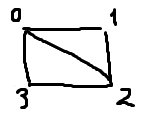

РЕЗУЛЬТАТ Классического решения
Максимальный разрез: 4
Оптимальные решения (2):
  0101
  1010

СРАВНЕНИЕ QAOA С РАЗНЫМ КОЛИЧЕСТВОМ СЛОЕВ p

ЗАПУСК QAOA С p = 2
QAOA ОПТИМИЗАЦИЯ ДЛЯ MAX-CUT (4 ВЕРШИНЫ)

1. Инициализация параметров (случайные значения):
   γ = [2.638 2.293]
   β = [0.002 1.739]
   Начальная энергия: -2.4792

2. Запуск классического оптимизатора (COBYLA)...
Начинаем оптимизацию QAOA (p=2)
Начальные параметры: [2.638e+00 2.293e+00 2.000e-03 1.739e+00]
Параметры: γ=[2.638 2.293], β=[0.002 1.739] -> Энергия: -2.5154
Параметры: γ=[3.638 2.293], β=[0.002 1.739] -> Энергия: -2.9514
Параметры: γ=[3.638 3.293], β=[0.002 1.739] -> Энергия: -2.2275
Параметры: γ=[3.638 2.293], β=[1.002 1.739] -> Энергия: -2.3164
Параметры: γ=[3.638 2.293], β=[2.000e-03 2.739e+00] -> Энергия: -1.1597
Параметры: γ=[3.848 1.945], β=[-0.303  0.878] -> Энергия: -1.1736
Параметры: γ=[3.714 2.168], β=[-0.108  2.204] -> Энергия: -2.1624
Параметры: γ=[3.684 2.217], β=[-0.065  1.516] -> Энергия: -2.4185
Парам

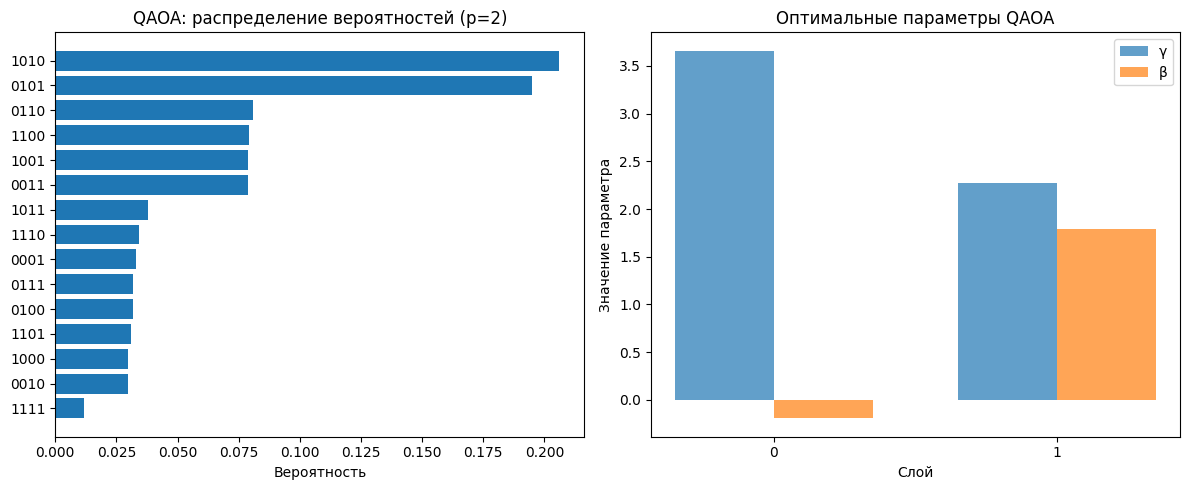


Результат для p=2:
  Начальная энергия: -2.4792
  Оптимальная энергия: -3.2161
  Разница: 0.7368

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
p     Параметров Нач.энергия  Опт.энергия  Улучшение 
------------------------------------------------------------
2     4          -2.4792      -3.2161      0.7368    


In [46]:
# Задача Max-Cut на 4-вершинном цикле
num_qubits = 4
edges = [(0, 1), (1, 2), (2, 3), (3, 0),   (0, 2)]

visualize_classical_solution(edges, num_qubits)
print()

# ====================
# 8. ЗАПУСК ПРОГРАММЫ 1
# ====================
result = compare_different_p(list_of_p=[2], optimal_solutions=['0101', '1010'])

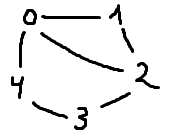

РЕЗУЛЬТАТ Классического решения
Максимальный разрез: 5
Оптимальные решения (4):
  00101
  01101
  10010
  11010

СРАВНЕНИЕ QAOA С РАЗНЫМ КОЛИЧЕСТВОМ СЛОЕВ p

ЗАПУСК QAOA С p = 2
QAOA ОПТИМИЗАЦИЯ ДЛЯ MAX-CUT (4 ВЕРШИНЫ)

1. Инициализация параметров (случайные значения):
   γ = [2.332 2.034]
   β = [0.991 1.635]
   Начальная энергия: -3.0791

2. Запуск классического оптимизатора (COBYLA)...
Начинаем оптимизацию QAOA (p=2)
Начальные параметры: [2.332 2.034 0.991 1.635]
Параметры: γ=[2.332 2.034], β=[0.991 1.635] -> Энергия: -3.0610
Параметры: γ=[3.332 2.034], β=[0.991 1.635] -> Энергия: -3.3184
Параметры: γ=[3.332 3.034], β=[0.991 1.635] -> Энергия: -3.6389
Параметры: γ=[3.332 3.034], β=[1.991 1.635] -> Энергия: -2.2080
Параметры: γ=[3.332 3.034], β=[0.991 2.635] -> Энергия: -1.6050
Параметры: γ=[3.434 3.161], β=[0.424 0.828] -> Энергия: -3.8311
Параметры: γ=[3.584 3.348], β=[-0.411  1.324] -> Энергия: -3.4106
Параметры: γ=[3.619 3.392], β=[0.692 0.527] -> Энергия: -2.1633
Параметры: γ=[3

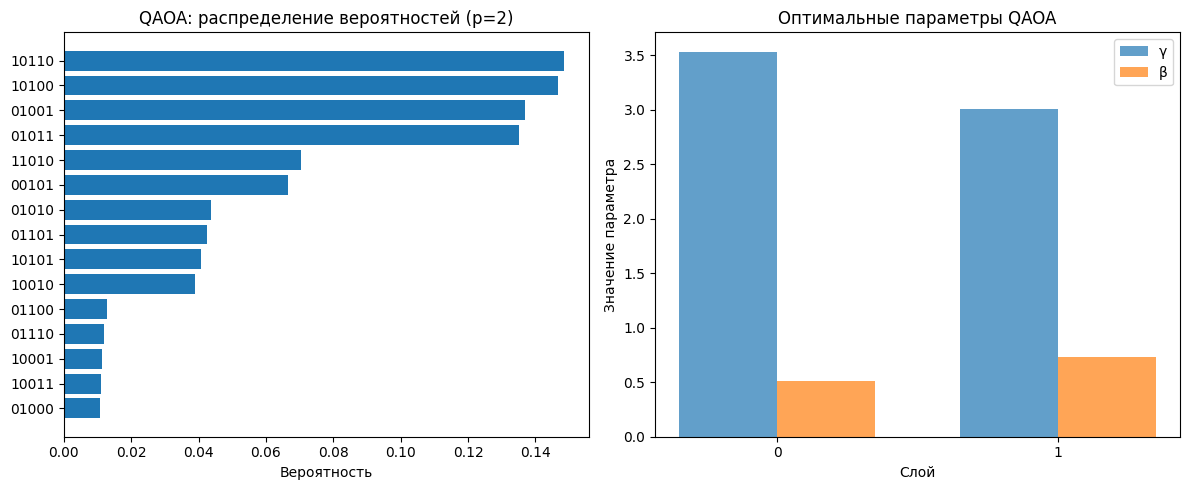


Результат для p=2:
  Начальная энергия: -3.0791
  Оптимальная энергия: -4.0454
  Разница: 0.9663

ЗАПУСК QAOA С p = 3
QAOA ОПТИМИЗАЦИЯ ДЛЯ MAX-CUT (4 ВЕРШИНЫ)

1. Инициализация параметров (случайные значения):
   γ = [2.332 0.574 1.067]
   β = [1.921 2.506 0.135]
   Начальная энергия: -1.7915

2. Запуск классического оптимизатора (COBYLA)...
Начинаем оптимизацию QAOA (p=3)
Начальные параметры: [2.332 0.574 1.067 1.921 2.506 0.135]
Параметры: γ=[2.332 0.574 1.067], β=[1.921 2.506 0.135] -> Энергия: -1.8049
Параметры: γ=[3.332 0.574 1.067], β=[1.921 2.506 0.135] -> Энергия: -2.7625
Параметры: γ=[3.332 1.574 1.067], β=[1.921 2.506 0.135] -> Энергия: -2.9954
Параметры: γ=[3.332 1.574 2.067], β=[1.921 2.506 0.135] -> Энергия: -2.2366
Параметры: γ=[3.332 1.574 1.067], β=[2.921 2.506 0.135] -> Энергия: -3.9958
Параметры: γ=[3.332 1.574 1.067], β=[2.921 3.506 0.135] -> Энергия: -3.7634
Параметры: γ=[3.332 1.574 1.067], β=[2.921 2.506 1.135] -> Энергия: -2.0295
Параметры: γ=[3.709 1.665 0.768]

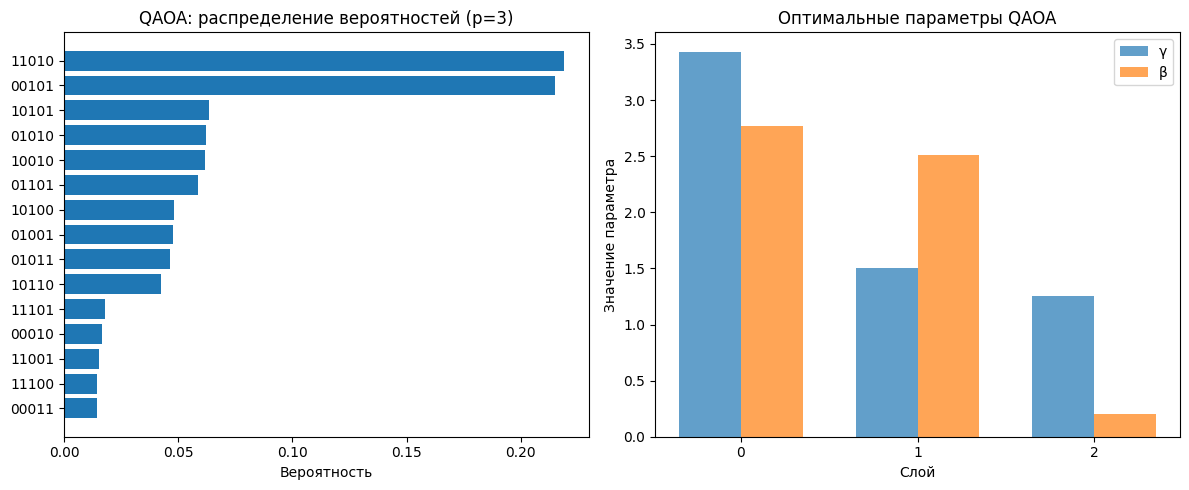


Результат для p=3:
  Начальная энергия: -1.7915
  Оптимальная энергия: -4.3699
  Разница: 2.5784

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
p     Параметров Нач.энергия  Опт.энергия  Улучшение 
------------------------------------------------------------
2     4          -3.0791      -4.0454      0.9663    
3     6          -1.7915      -4.3699      2.5784    


In [52]:
# Задача Max-Cut на графе из 5 рёбер
num_qubits = 5
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 0),   (0, 2)]

max_cut, optimal, all_solutions = visualize_classical_solution(edges, num_qubits)
print()

# ====================
# 8. ЗАПУСК ПРОГРАММЫ QAUA
# ====================
result = compare_different_p(list_of_p=[2, 3], optimal_solutions=optimal)